![](/banner.png)

![](banner.png)
# Objetivos
+ Cargar los datos de una base de datos oltp y realizar limpieza
+ Perfilar los datos recibidos
+ Conseguir un conjunto de datos relacionado con toda la información a excluyendo municipio
+ Conseguir un conjunto de datos relacionado únicamente con los totales por municipio en cada año

# Carga de librerias

In [193]:
#Librerias para trabajar los datos
import pandas as pd
import numpy as np

#Librerias para visualizar los datos
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
#Otras
import math
from matplotlib import cm
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler


# just in case

seed = 161
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler

# Carga de datos

In [124]:
#Carga de los datos principales
df_main = pd.read_csv('/data/data_generateddata_ready.csv',sep=',',index_col=False,low_memory=False)

In [125]:
df_main.head()

,anio,codigo_depto,nombre_depto,nombre_muni,codigo_muni,codigo_evento,evento,edad,sexo,num_casos,población
0,2020,5,Antioquia,Abejorral,5002,102,Tuberculosis,15-44 años,Hombres,1,4393
1,2020,5,Antioquia,Abejorral,5002,501,Accidentes de transporte terrestre,15-44 años,Hombres,1,4393
2,2020,5,Antioquia,Abejorral,5002,511,Lesiones autoinfligidas intencionalmente (suic...,15-44 años,Hombres,1,4393
3,2020,5,Antioquia,Abejorral,5002,512,Agresiones (homicidios),15-44 años,Hombres,1,4393
4,2020,5,Antioquia,Abejorral,5002,108,Infecciones respiratorias agudas,65+ años,Hombres,1,1358


# Limpieza
## Datos principales
En principio vamos a eliminar los elementos que calculan totales en el dataframe para que todas las filas representen lo mismo

In [126]:
df_main = df_main.drop(df_main[df_main['codigo_depto']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['nombre_depto']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['nombre_muni']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['codigo_muni']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['codigo_evento']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['evento']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['edad']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['sexo']=='TOTAL'].index)

Luego revisamos los tipos de datos y transformamos lo que sea necesario

In [127]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42254 entries, 0 to 42253
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   anio           42254 non-null  int64 
 1   codigo_depto   42254 non-null  int64 
 2   nombre_depto   42254 non-null  object
 3   nombre_muni    42254 non-null  object
 4   codigo_muni    42254 non-null  int64 
 5   codigo_evento  42254 non-null  int64 
 6   evento         42254 non-null  object
 7   edad           42254 non-null  object
 8   sexo           42254 non-null  object
 9   num_casos      42254 non-null  int64 
 10  población      42254 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 4.9+ MB


In [128]:
def arreglar_tipos(v_types:dict) -> None:
    for value in v_types:
        try:
            df_main[value] = df_main[value].astype(v_types[value])
        except Exception as e:
            print(f'error in value {value}',str(e))
        
value_types = {'anio':'int64','codigo_depto':'int64','nombre_depto':'string',
               'nombre_muni':'string','codigo_muni':'int64','codigo_evento':'int64',
               'evento':'string','sexo':'string','edad':'string','num_casos':'int64'
              }

arreglar_tipos(value_types)

Vemos que en la columna codigo_depto hay un elemento llamado 'Extranjeros', asi que lo vamos a cambiar por el código 100

In [129]:
df_main['codigo_depto'] = df_main['codigo_depto'].apply(lambda x : 100 if x == 'Extranjeros' else x)

In [130]:
def porcentaje (row):
    return row['num_casos']/row['población']

In [131]:
df_main['porcentaje'] = df_main.apply (lambda row: porcentaje(row), axis=1)

In [132]:
df_main.head()

,anio,codigo_depto,nombre_depto,nombre_muni,codigo_muni,codigo_evento,evento,edad,sexo,num_casos,población,porcentaje
0,2020,5,Antioquia,Abejorral,5002,102,Tuberculosis,15-44 años,Hombres,1,4393,0.000228
1,2020,5,Antioquia,Abejorral,5002,501,Accidentes de transporte terrestre,15-44 años,Hombres,1,4393,0.000228
2,2020,5,Antioquia,Abejorral,5002,511,Lesiones autoinfligidas intencionalmente (suic...,15-44 años,Hombres,1,4393,0.000228
3,2020,5,Antioquia,Abejorral,5002,512,Agresiones (homicidios),15-44 años,Hombres,1,4393,0.000228
4,2020,5,Antioquia,Abejorral,5002,108,Infecciones respiratorias agudas,65+ años,Hombres,1,1358,0.000736


In [133]:
df_main["c/1000"] = df_main["num_casos"] / df_main["población"] * 1000
df_main["c/1000"] = df_main["c/1000"].apply(lambda x : round(x,5))
df_main["c/10000"] = df_main["num_casos"] / df_main["población"] * 10000
df_main["c/10000"] = df_main["c/10000"].apply(lambda x : round(x,5))
df_main["c/100000"] = df_main["num_casos"] / df_main["población"] * 100000
df_main["c/100000"] = df_main["c/100000"].apply(lambda x : round(x,5))

In [134]:
df_main.head()

,anio,codigo_depto,nombre_depto,nombre_muni,codigo_muni,codigo_evento,evento,edad,sexo,num_casos,población,porcentaje,c/1000,c/10000,c/100000
0,2020,5,Antioquia,Abejorral,5002,102,Tuberculosis,15-44 años,Hombres,1,4393,0.000228,0.22763,2.27635,22.76349
1,2020,5,Antioquia,Abejorral,5002,501,Accidentes de transporte terrestre,15-44 años,Hombres,1,4393,0.000228,0.22763,2.27635,22.76349
2,2020,5,Antioquia,Abejorral,5002,511,Lesiones autoinfligidas intencionalmente (suic...,15-44 años,Hombres,1,4393,0.000228,0.22763,2.27635,22.76349
3,2020,5,Antioquia,Abejorral,5002,512,Agresiones (homicidios),15-44 años,Hombres,1,4393,0.000228,0.22763,2.27635,22.76349
4,2020,5,Antioquia,Abejorral,5002,108,Infecciones respiratorias agudas,65+ años,Hombres,1,1358,0.000736,0.73638,7.36377,73.63770


In [135]:
df_main = df_main.drop(columns=['num_casos','población','porcentaje','c/1000','c/100000'])

In [136]:
df_main.head()

,anio,codigo_depto,nombre_depto,nombre_muni,codigo_muni,codigo_evento,evento,edad,sexo,c/10000
0,2020,5,Antioquia,Abejorral,5002,102,Tuberculosis,15-44 años,Hombres,2.27635
1,2020,5,Antioquia,Abejorral,5002,501,Accidentes de transporte terrestre,15-44 años,Hombres,2.27635
2,2020,5,Antioquia,Abejorral,5002,511,Lesiones autoinfligidas intencionalmente (suic...,15-44 años,Hombres,2.27635
3,2020,5,Antioquia,Abejorral,5002,512,Agresiones (homicidios),15-44 años,Hombres,2.27635
4,2020,5,Antioquia,Abejorral,5002,108,Infecciones respiratorias agudas,65+ años,Hombres,7.36377


In [137]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42254 entries, 0 to 42253
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   anio           42254 non-null  int64  
 1   codigo_depto   42254 non-null  int64  
 2   nombre_depto   42254 non-null  string 
 3   nombre_muni    42254 non-null  string 
 4   codigo_muni    42254 non-null  int64  
 5   codigo_evento  42254 non-null  int64  
 6   evento         42254 non-null  string 
 7   edad           42254 non-null  string 
 8   sexo           42254 non-null  string 
 9   c/10000        42254 non-null  float64
dtypes: float64(1), int64(4), string(5)
memory usage: 4.6 MB


Volvemos a intentar castear tipos

In [138]:
df_main.shape


(42254, 10)

In [139]:
df_main.isnull().sum(axis=0)

anio             0
codigo_depto     0
nombre_depto     0
nombre_muni      0
codigo_muni      0
codigo_evento    0
evento           0
edad             0
sexo             0
c/10000          0
dtype: int64

Todo correcto

# Transformaciones
En caso de no contar con la cantidad de población determinada para algún grupo vamos a retirar esta información por lo que retiraremos los valores referentes a:
+ Muertes en el extranjero (columna codigo_depto con el valor 100)
+ Muertes de sexo indeterminado (columna sexo con el valor "Indeterminado")
+ Muertes de edad desconocida (columna edad con valor "Edad Desconocida")

In [140]:
df_main.groupby(['sexo','anio','edad','codigo_depto','nombre_depto','codigo_evento','evento']).sum()


codigo_muni  \
sexo    anio edad     codigo_depto nombre_depto codigo_evento evento                                                            
Hombres 2020 0-4 años 5            Antioquia    0             Signos, síntomas y afecciones mal definidas               21842   
                                                101           Enfermedades infecciosas intestinales                     20635   
                                                105           Meningitis                                                16417   
                                                106           Septicemia, excepto neonatal                              17043   
                                                108           Infecciones respiratorias agudas                          22505   
...                                                                                                                       ...   
Mujeres 2020 65+ años 99           Vichada      302           Enfermedades hipertensivas                                99773   
                                                303           Enfermedades isquémicas del corazón                      198525   
                                                601           Diabetes mellitus                                        199297   
                                                605           Enfermedades crónicas de las vías respiratorias...        99001   
                                                609           Resto de enfermedades del sistema digestivo               99773   

                                                                                                                    c/10000  
sexo    anio edad     codigo_depto nombre_depto codigo_evento evento                                                         
Hombres 2020 0-4 años 5            Antioquia    0             Signos, síntomas y afecciones mal definidas          16.38934  
                                                101           Enfermedades infecciosas intestinales                22.01371  
                                                105           Meningitis                                           29.44498  
                                                106           Septicemia, excepto neonatal                         16.74798  
                                                108           Infecciones respiratorias agudas                     32.24550  
...                                                                                                                     ...  
Mujeres 2020 65+ años 99           Vichada      302           Enfermedades hipertensivas                            9.19118  
                                                303           Enfermedades isquémicas del corazón                 114.72868  
                                                601           Diabetes mellitus                                    53.63562  
                                                605           Enfermedades crónicas de las vías respiratorias...   25.83979  
                                                609           Resto de enfermedades del sistema digestivo           9.19118  

[8455 rows x 2 columns]

In [141]:
#solo hay 1 año (2020)
df_main = df_main.drop(['codigo_depto','codigo_muni','codigo_evento','nombre_muni','anio'],axis = 1)

In [142]:
encoder = ce.OneHotEncoder(cols="sexo", use_cat_names=True)
dfmod = encoder.fit_transform(df_main)

In [143]:
dfmod.head()

,nombre_depto,evento,edad,sexo_Hombres,sexo_Mujeres,c/10000
0,Antioquia,Tuberculosis,15-44 años,1,0,2.27635
1,Antioquia,Accidentes de transporte terrestre,15-44 años,1,0,2.27635
2,Antioquia,Lesiones autoinfligidas intencionalmente (suic...,15-44 años,1,0,2.27635
3,Antioquia,Agresiones (homicidios),15-44 años,1,0,2.27635
4,Antioquia,Infecciones respiratorias agudas,65+ años,1,0,7.36377


In [144]:
df_main.shape

(42254, 5)

In [145]:
dfmod.shape

(42254, 6)

In [146]:
print(df_main['evento'].unique())

<StringArray>
[                                                                                               'Tuberculosis',
                                                                          'Accidentes de transporte terrestre',
                                                        'Lesiones autoinfligidas intencionalmente (suicidios)',
                                                                                     'Agresiones (homicidios)',
                                                                            'Infecciones respiratorias agudas',
                            'Tumor maligno de los órganos digestivos y del peritoneo excepto estómago y colon',
                                                                                'Tumor maligno de la próstata',
                                                                                  'Enfermedades hipertensivas',
                                                                         'Enfermedades isq

In [147]:
dfmod.loc[dfmod['evento'].str.contains('enfermedad',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('tumor',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('infeccion',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('leucemia',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('tuberculosis',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('insuficiencia',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('diabetes',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('apendicitis',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('trastorno',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('malformacion',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('signos',  case=False), 'evento'] = 'INDETERMINADA'
dfmod.loc[dfmod['evento'].str.contains('aterosclerosis',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('deficiencia',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('meningitis',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('retardo',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('afecciones',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('embarazo',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('complicacion',  case=False), 'evento'] = 'MUERTE_ACCIDENTAL'
dfmod.loc[dfmod['evento'].str.contains('sepsis',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('hiperplasia',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('septicemia',  case=False), 'evento'] = 'CAUSA_NATURAL'
dfmod.loc[dfmod['evento'].str.contains('accident',  case=False), 'evento'] = 'MUERTE_ACCIDENTAL'
dfmod.loc[dfmod['evento'].str.contains('ahogamiento',  case=False), 'evento'] = 'MUERTE_ACCIDENTAL'
dfmod.loc[dfmod['evento'].str.contains('corriente',  case=False), 'evento'] = 'MUERTE_ACCIDENTAL'
dfmod.loc[dfmod['evento'].str.contains('caídas',  case=False), 'evento'] = 'MUERTE_ACCIDENTAL'
dfmod.loc[dfmod['evento'].str.contains('fuego',  case=False), 'evento'] = 'MUERTE_ACCIDENTAL'
dfmod.loc[dfmod['evento'].str.contains('externa',  case=False), 'evento'] = 'MUERTE_ACCIDENTAL'
dfmod.loc[dfmod['evento'].str.contains('suicidio',  case=False), 'evento'] = 'SUICIDIO'
dfmod.loc[dfmod['evento'].str.contains('homicidio',  case=False), 'evento'] = 'HOMICIDIO'
dfmod.loc[dfmod['evento'].str.contains('determinada',  case=False), 'evento'] = 'INDETERMINADA'


In [148]:
print(df_main['nombre_depto'].unique())

#se dividirá por regiones para el analisis.

<StringArray>
[         'Antioquia',          'Atlántico',             'Bogotá',
            'Bolívar',             'Boyacá',             'Caldas',
            'Caquetá',              'Cauca',              'Cesar',
            'Córdoba',       'Cundinamarca',              'Chocó',
              'Huila',         'La Guajira',          'Magdalena',
               'Meta',             'Nariño', 'Norte de Santander',
            'Quindío',          'Risaralda',          'Santander',
              'Sucre',             'Tolima',    'Valle del Cauca',
             'Arauca',           'Casanare',           'Putumayo',
           'Amazonas',            'Guainía',           'Guaviare',
             'Vaupés',            'Vichada']
Length: 32, dtype: string


In [149]:
dfmod.loc[dfmod['nombre_depto'].isin(['Atlántico','Bolívar','Cesar','Córdoba','La Guajira','Sucre','Magdalena']), 'region'] = 'Caribe'
dfmod.loc[dfmod['nombre_depto'].isin(['Chocó','Valle del Cauca','Cauca','Nariño']), 'region'] = 'Pacífico'
dfmod.loc[dfmod['nombre_depto'].isin(['Meta','Vichada','Casanare','Arauca']), 'region'] = 'Orinoquía'
dfmod.loc[dfmod['nombre_depto'].isin(['Antioquia','Boyacá','Cundinamarca','Huila','Bogotá','Norte de Santander','Quindío','Risaralda','Santander','Tolima','Caldas']), 'region'] = 'Andina'
dfmod.loc[dfmod['nombre_depto'].isin(['Caquetá','Amazonas','Guainía','Guaviare','Putumayo','Vaupés']), 'region'] = 'Amazonía'


In [150]:
print(dfmod['region'].unique())

['Andina' 'Caribe' 'Amazonía' 'Pacífico' 'Orinoquía']


In [151]:
dfmod = dfmod.drop(['nombre_depto'],axis = 1)

In [152]:
print(dfmod['evento'].unique())

<StringArray>
['CAUSA_NATURAL', 'MUERTE_ACCIDENTAL', 'SUICIDIO', 'HOMICIDIO',
 'INDETERMINADA']
Length: 5, dtype: string


In [153]:
dfmod.head()

,evento,edad,sexo_Hombres,sexo_Mujeres,c/10000,region
0,CAUSA_NATURAL,15-44 años,1,0,2.27635,Andina
1,MUERTE_ACCIDENTAL,15-44 años,1,0,2.27635,Andina
2,SUICIDIO,15-44 años,1,0,2.27635,Andina
3,HOMICIDIO,15-44 años,1,0,2.27635,Andina
4,CAUSA_NATURAL,65+ años,1,0,7.36377,Andina


In [154]:
encoderdepto = ce.OneHotEncoder(cols="region", use_cat_names=True)
dfs = encoderdepto.fit_transform(dfmod)
dfs.shape

(42254, 10)

In [155]:
encoderedad = ce.OneHotEncoder(cols="edad", use_cat_names=True)

In [156]:
dff = encoderedad.fit_transform(dfs)

In [157]:
dff.head()

,evento,edad_15-44 años,edad_65+ años,edad_45-64 años,edad_5-14 años,edad_0-4 años,sexo_Hombres,sexo_Mujeres,c/10000,region_Andina,region_Caribe,region_Amazonía,region_Pacífico,region_Orinoquía
0,CAUSA_NATURAL,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
1,MUERTE_ACCIDENTAL,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
2,SUICIDIO,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
3,HOMICIDIO,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
4,CAUSA_NATURAL,0,1,0,0,0,1,0,7.36377,1,0,0,0,0


# Perfilamiento

### sexo

In [158]:
dff.groupby(by='sexo_Mujeres')['c/10000'].sum()

sexo_Mujeres
0    266214.91829
1    200786.93796
Name: c/10000, dtype: float64

In [159]:
dff.groupby(by='sexo_Hombres')['c/10000'].sum()

sexo_Hombres
0    200786.93796
1    266214.91829
Name: c/10000, dtype: float64

<AxesSubplot:xlabel='sexo_Hombres'>

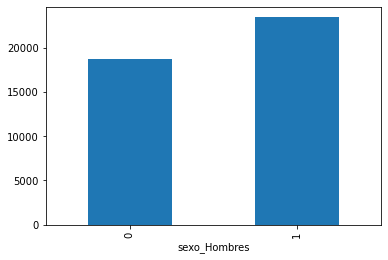

In [160]:
sexo_counts = dff.groupby('sexo_Hombres')['c/10000'].count()
sexo_counts.plot(kind='bar')

### Evento

In [161]:
dff.groupby(by='evento')['c/10000'].sum().sort_values()

evento
SUICIDIO               2588.20478
HOMICIDIO              7019.13851
INDETERMINADA         13774.68185
MUERTE_ACCIDENTAL     15535.59928
CAUSA_NATURAL        428084.23183
Name: c/10000, dtype: float64

<AxesSubplot:xlabel='evento'>

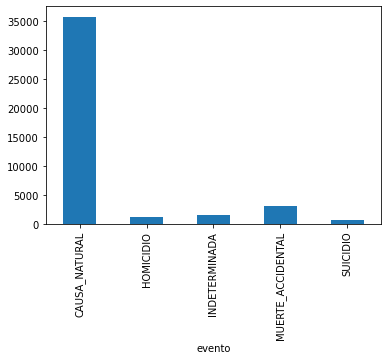

In [162]:
evento_counts = dff.groupby('evento')['c/10000'].count()
evento_counts.plot(kind='bar')

#comparado con la anterior, nos permite categorizar mejor.

### Region

In [163]:
dff.groupby(by='region_Andina')['c/10000'].sum().sort_values()

region_Andina
0    196591.83743
1    270410.01882
Name: c/10000, dtype: float64

In [164]:
dff.groupby(by='region_Caribe')['c/10000'].sum().sort_values()

region_Caribe
1     85796.02605
0    381205.83020
Name: c/10000, dtype: float64

In [165]:
dff.groupby(by='region_Amazonía')['c/10000'].sum().sort_values()


region_Amazonía
1     16158.61413
0    450843.24212
Name: c/10000, dtype: float64

In [166]:
dff.groupby(by='region_Pacífico')['c/10000'].sum().sort_values()


region_Pacífico
1     69654.16341
0    397347.69284
Name: c/10000, dtype: float64

In [167]:

dff.groupby(by='region_Orinoquía')['c/10000'].sum().sort_values()


region_Orinoquía
1     24983.03384
0    442018.82241
Name: c/10000, dtype: float64

### Edad

In [168]:
dff.groupby(by='edad_0-4 años')['c/10000'].sum().sort_values()

edad_0-4 años
1     19224.48433
0    447777.37192
Name: c/10000, dtype: float64

In [169]:
dff.groupby(by='edad_15-44 años')['c/10000'].sum().sort_values()

edad_15-44 años
1     14645.35436
0    452356.50189
Name: c/10000, dtype: float64

In [170]:
dff.groupby(by='edad_45-64 años')['c/10000'].sum().sort_values()

edad_45-64 años
1     51536.38301
0    415465.47324
Name: c/10000, dtype: float64

In [171]:
dff.groupby(by='edad_65+ años')['c/10000'].sum().sort_values()

edad_65+ años
0     88106.64595
1    378895.21030
Name: c/10000, dtype: float64

Arreglamos el indice y quitamos codigo_muni

Vamos a crear una columna en el dataframe df1 y en el dataframe df_población_datos que nos ayude a hacer la relación que queremos para mapear rangos de edad

# Modelo

In [172]:

y = dff.evento
x = dff.drop(['evento'],axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [173]:
logisticRegr = LogisticRegression()

In [174]:
logisticRegr.fit(x_train, y_train)

LogisticRegression()

In [175]:
predictions=logisticRegr.predict(x_test)

In [176]:
score = logisticRegr.score(x_test, y_test)
print(score)

0.84967815221507


## Clustering


Reescalamos 

In [177]:
dff.head()

,evento,edad_15-44 años,edad_65+ años,edad_45-64 años,edad_5-14 años,edad_0-4 años,sexo_Hombres,sexo_Mujeres,c/10000,region_Andina,region_Caribe,region_Amazonía,region_Pacífico,region_Orinoquía
0,CAUSA_NATURAL,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
1,MUERTE_ACCIDENTAL,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
2,SUICIDIO,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
3,HOMICIDIO,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
4,CAUSA_NATURAL,0,1,0,0,0,1,0,7.36377,1,0,0,0,0


In [178]:
encoder = ce.OneHotEncoder(cols="evento", use_cat_names=True)
df_final = encoder.fit_transform(dff)



In [179]:
df_final.head()

,evento_CAUSA_NATURAL,evento_MUERTE_ACCIDENTAL,evento_SUICIDIO,evento_HOMICIDIO,evento_INDETERMINADA,edad_15-44 años,edad_65+ años,edad_45-64 años,edad_5-14 años,edad_0-4 años,sexo_Hombres,sexo_Mujeres,c/10000,region_Andina,region_Caribe,region_Amazonía,region_Pacífico,region_Orinoquía
0,1,0,0,0,0,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
2,0,0,1,0,0,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,1,0,2.27635,1,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,1,0,7.36377,1,0,0,0,0


In [180]:
trans = MinMaxScaler()
trans.fit(df_final)

df_finalt = pd.DataFrame(trans.transform(df_final), columns = df_final.columns)
df_finalt.describe()

,evento_CAUSA_NATURAL,evento_MUERTE_ACCIDENTAL,evento_SUICIDIO,evento_HOMICIDIO,evento_INDETERMINADA,edad_15-44 años,edad_65+ años,edad_45-64 años,edad_5-14 años,edad_0-4 años,sexo_Hombres,sexo_Mujeres,c/10000,region_Andina,region_Caribe,region_Amazonía,region_Pacífico,region_Orinoquía
count,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000,42254.000000
mean,0.848440,0.071094,0.016093,0.027713,0.036659,0.159038,0.509964,0.253727,0.019430,0.057841,0.556089,0.443911,0.029275,0.516945,0.231623,0.030246,0.173948,0.047238
std,0.358598,0.256985,0.125835,0.164152,0.187926,0.365716,0.499907,0.435149,0.138033,0.233445,0.496850,0.496850,0.042953,0.499719,0.421874,0.171265,0.379069,0.212150
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004685,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.014676,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.035462,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [188]:
#Creamos una función basada en el concepto de silueta
def plot_silhouette(data, 
                    labels,
                   ylabel = 'Clústeres',
                   xlabel = "Silhouette coefficient",
                   title = 'Silhouette Plot'):
    '''
    Graficar la silueta de los clusters
    
    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    labels : np.array
        El arreglo con las etiquetas correspondientes
    ylabel  string
        La etiqueta del eje y
    xlabel : string
        La etiqueta del eje x
    title : string
        El titulo de la gráfica        
    '''
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data,
                                        labels,
                                        metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,
                color="red",
                linestyle="--")
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

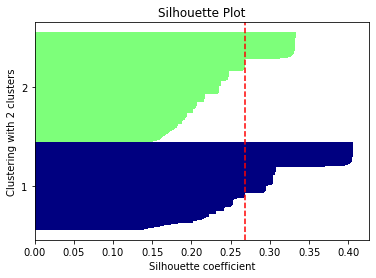

In [192]:
# Esta función puede tardar varios minutos
n_clusters = 2
km = KMeans(n_clusters=n_clusters, random_state=1)
km.fit(df_finalt)
plot_silhouette(data = df_finalt, 
                labels = km.labels_, 
                ylabel = f'Clustering with {n_clusters} clusters')

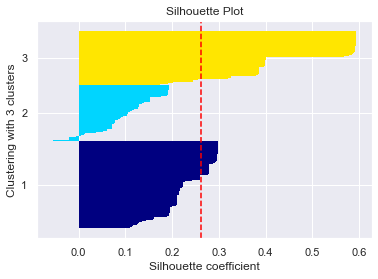

In [194]:
# Esta función puede tardar varios minutos
n_clusters = 3
km = KMeans(n_clusters=n_clusters, random_state=1)
km.fit(df_finalt)
plot_silhouette(data = df_finalt, 
                labels = km.labels_, 
                ylabel = f'Clustering with {n_clusters} clusters')

Dado que este ya da negativos, se consideran 2 clusters como la mejor.

In [196]:
n_clusters = 2
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(df_finalt)

KMeans(n_clusters=2, random_state=161)

In [197]:
df_pro3 = pd.DataFrame(km.cluster_centers_, columns = df_finalt.columns)
df_pro3

,evento_CAUSA_NATURAL,evento_MUERTE_ACCIDENTAL,evento_SUICIDIO,evento_HOMICIDIO,evento_INDETERMINADA,edad_15-44 años,edad_65+ años,edad_45-64 años,edad_5-14 años,edad_0-4 años,sexo_Hombres,sexo_Mujeres,c/10000,region_Andina,region_Caribe,region_Amazonía,region_Pacífico,region_Orinoquía
0,0.804826,0.092395,0.022556,0.040090,0.040133,0.171681,0.489382,0.259437,0.02030,0.059199,1.000000e+00,3.774758e-15,0.030011,0.517513,0.229902,0.031281,0.173086,0.048219
1,0.903076,0.044410,0.007997,0.012209,0.032308,0.143200,0.535747,0.246575,0.01834,0.056139,-3.663736e-15,1.000000e+00,0.028354,0.516234,0.233779,0.028949,0.175028,0.046009


In [199]:
df_pro3_t = pd.DataFrame(np.transpose(km.cluster_centers_), columns = range(1, n_clusters +1))
df_pro3_t['column'] = df_finalt.columns
df_pro3_t

,1,2,column
0,8.048261e-01,9.030762e-01,evento_CAUSA_NATURAL
1,9.239477e-02,4.441009e-02,evento_MUERTE_ACCIDENTAL
2,2.255607e-02,7.997014e-03,evento_SUICIDIO
3,4.009022e-02,1.220878e-02,evento_HOMICIDIO
4,4.013278e-02,3.230794e-02,evento_INDETERMINADA
5,1.716815e-01,1.431999e-01,edad_15-44 años
6,4.893816e-01,5.357467e-01,edad_65+ años
7,2.594374e-01,2.465746e-01,edad_45-64 años
8,2.030046e-02,1.833982e-02,edad_5-14 años
9,5.919905e-02,5.613904e-02,edad_0-4 años


<AxesSubplot:xlabel='value', ylabel='column'>

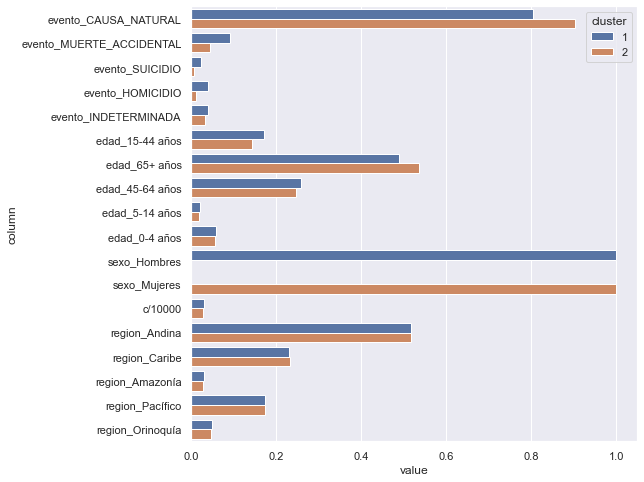

In [200]:
resp = []
for i in range(1, n_clusters +1):
    df1 = df_pro3_t[['column',i]].rename(columns = {i:'value'})
    df1['cluster'] = i
    resp.append(df1)

df_plot = pd.concat(resp, ignore_index = True)


fig = plt.figure(figsize=(8,8))
sns.barplot(data = df_plot, y = 'column', x = 'value', hue = 'cluster', orient = 'h')